In [18]:
# Import relevant libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

In [44]:
# hyperparameters
regression = Ridge
# threshold step size for the ROC curve
step_size = 0.0001
# offset to prevent dividing by 0
eps = 10**-8

In [19]:
# load data
train = pd.read_csv("data/random_train0314.csv")
test = pd.read_csv("data/random_test0314.csv")
val = pd.read_csv("data/random_val0314.csv")

print train.dtypes

BorrCity                              object
BorrState                             object
BorrZip                               object
CDC_City                              object
CDC_State                             object
CDC_Zip                               object
ThirdPartyLender_City                 object
ThirdPartyLender_State                object
GrossApproval                        float64
ApprovalDate                          object
ApprovalFiscalYear                     int64
DeliveryMethod                        object
subpgmdesc                            object
TermInMonths                           int64
ProjectCounty                         object
ProjectState                          object
BusinessType                          object
LoanStatus                            object
ChargeOffDate                         object
GrossChargeOffAmount                 float64
SP500_Yearly_Return                  float64
CPI                                  float64
Yearly_Une

In [21]:
# remove variables we don't want
c = train.columns.tolist()
dropped_columns = ['LoanStatus', 'GrossChargeOffAmount', 'BorrZip', 'CDC_Zip', 'BorrCity',
                   'CDC_City', 'ThirdPartyLender_City', 'ProjectCounty', 'ApprovalDate',
                   'CDC_State', 'ThirdPartyLender_State', 'ProjectState', 'ChargeOffDate',
                   'Yearly_Unemployment_Rate', 'DeliveryMethod']
for col in dropped_columns:
    c.remove(col)
print(len(c)), "covariates"
print c

17 covariates
['BorrState', 'GrossApproval', 'ApprovalFiscalYear', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics']


In [22]:
x_train = train[c]
x_test = test[c]
x_val = val[c]

print x_train.shape

(43844, 17)


In [23]:
# estimate how many covariates we add by the expanding categorical columns
numerics = x_train.select_dtypes(include=[np.number,'bool'])
cats = x_train.drop(columns=numerics.columns)

uniques = np.unique(cats.values)

print "approx. number of covariate levels:", len(uniques)
print cats.dtypes

approx. number of covariate levels: 87
BorrState       object
subpgmdesc      object
BusinessType    object
2DigitNaics     object
dtype: object


In [24]:
x_train = pd.get_dummies(x_train, columns = cats.columns)
x_test = pd.get_dummies(x_test)
x_val = pd.get_dummies(x_val)

print x_train.shape

def add_missing_columns(d1, d2):
    missing_cols_2 = (set(d1.columns) - set(d2.columns))
    missing_cols_1 = (set(d2.columns) - set(d1.columns))
    for c in missing_cols_2:
        d2[c] = 0
    for c in missing_cols_1:
        d1[c] = 0
    return d1, d2

x_train, x_test = add_missing_columns(x_train, x_test)
x_train, x_val = add_missing_columns(x_train, x_val)
x_test, x_val = add_missing_columns(x_test, x_val)

# x_train = x_train.astype(float)
# x_test = x_test.astype(float)
# x_val = x_val.astype(float)

print x_train.shape

(43844, 101)
(43844, 101)


In [27]:
# create target variables
y_train = (train['LoanStatus'].values == "CHGOFF")*1
y_test = (test['LoanStatus'].values == "CHGOFF")*1
y_val = (val['LoanStatus'].values == "CHGOFF")*1

print train['LoanStatus'].values[:5]
print np.sum(y_train == 1, dtype=float) / len(y_train)

['CHGOFF' 'PIF' 'PIF' 'PIF' 'PIF']
0.16369400602134843


In [31]:
# hyperparameter search
alpha_range = [2**i for i in range(-5,10)]
u_results = {}
for alpha in alpha_range:
    model = regression(alpha = alpha)
    model.fit(x_train, y_train)
    u = model.score(x_val,y_val)
    u_results[u] = alpha
opt_u = np.max(u_results.keys())
opt_setting = u_results[opt_u]

print opt_setting, ":", opt_u

64 : 0.17211237899318166


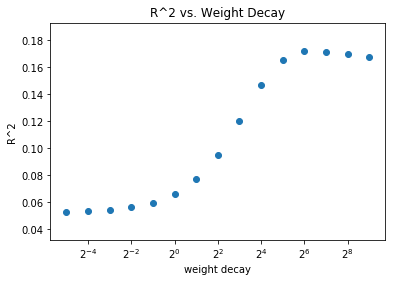

In [39]:
plt.title("R^2 vs. Weight Decay")
plt.ylabel("R^2")
plt.xlabel("weight decay")

plt.xscale('log', basex = 2)
plt.scatter(u_results.values(), u_results.keys())
plt.show()

In [34]:
opt_alpha = opt_setting

model = regression(alpha = opt_alpha)
model.fit(x_train, y_train)

Ridge(alpha=64, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [61]:
# train performance
print 'Training set performance'
print 'R^2:', model.score(x_train, y_train)
l2_loss = np.sum((np.maximum(model.predict(x_train),0) - y_train)**2)/len(y_train)
print 'L2 loss:', l2_loss 

# test performance
print '\nTest set performance'
print 'R^2:', model.score(x_test, y_test)
l2_loss = np.sum((np.maximum(model.predict(x_test),0) - y_test)**2)/len(y_test)
print 'L2 loss:', l2_loss

Training set performance
R^2: 0.22631949105569948
L2 loss: 0.10491788669835059

Test set performance
R^2: 0.16107910607377662
L2 loss: 0.10851294034404586


In [36]:
model.predict(x_train[:20])

array([ 0.12317014,  0.34475603,  0.07294155,  0.12434571,  0.1169119 ,
        0.04801888,  0.09109369,  0.38907675,  0.46870404,  0.04962448,
        0.18406121,  0.04067563,  0.31407968,  0.18377079,  0.1401406 ,
        0.04683821,  0.0687392 , -0.04613194,  0.17487301,  0.33984713])

In [37]:
model.predict(x_test[:20])

array([ 0.11156058,  0.00365175,  0.31261274, -0.01632954,  0.39082517,
        0.30784704,  0.7960511 ,  0.28056041, -0.13508781, -0.03428113,
        0.40810775,  0.35504106,  0.14535111,  0.35509029,  0.2479628 ,
        0.08785519,  0.10608985, -0.01723347,  0.16924674,  0.15957149])

In [62]:
# generate ROC curve
y_probs_val = np.maximum(model.predict(x_val),0)
y_probs_train = np.maximum(model.predict(x_train),0)

train_fprs, train_tprs, val_fprs, val_tprs  = [], [], [], []
for threshold in np.arange(step_size,1,step_size):
    y_preds_val = y_probs_val > threshold
    val_fprs.append(np.sum((y_val == 0) * (y_preds_val == 1)) / (np.sum(y_val == 0) + eps))
    val_tprs.append(np.sum((y_val == 1) * (y_preds_val == 1)) / (np.sum(y_val == 1) + eps))
    
    y_preds_train = y_probs_train > threshold
    train_fprs.append(np.sum((y_train == 0) * (y_preds_train == 1)) / (np.sum(y_train == 0) + eps))
    train_tprs.append(np.sum((y_train == 1) * (y_preds_train == 1)) / (np.sum(y_train == 1) + eps))
print val_fprs[:4]
print val_tprs[:4]

[0.803050397876209, 0.803050397876209, 0.8021662245782446, 0.8019451812537535]
[0.9665621734486253, 0.9665621734486253, 0.9665621734486253, 0.9665621734486253]


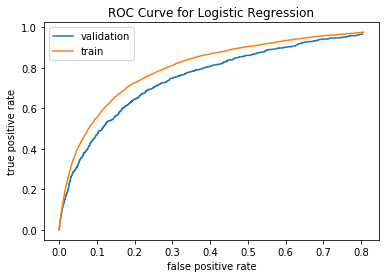

In [63]:
# plot ROC curve
plt.title("ROC Curve for Logistic Regression")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")

valplt, = plt.plot(val_fprs,val_tprs,label='validation')
trainplt, = plt.plot(train_fprs,train_tprs,label='train')
plt.legend(handles = [valplt, trainplt])

plt.show()

In [64]:
# calculate AUC
auc = 0
x_prev = 0
for x, y in zip(sorted(val_fprs), sorted(val_tprs)):
    auc += (x - x_prev)*y
    x_prev = x
print auc

0.597608297362921


In [66]:
# save ROC curve
with open("linear_roc.csv", "w") as file:
    file.write("threshold,fpr,tpr\n")
    for i, (fpr, tpr) in enumerate(zip(val_fprs, val_tprs), 1):
        file.write(str(step_size * i) + "," + str(fpr) + "," + str(tpr) + "\n")
print "done"

done


In [50]:
# find best threshold
senses = np.array(val_tprs, dtype=float) + eps
specs = 1 - np.array(val_fprs, dtype=float) + eps
# h_mean = 2. / (1 / senses + 1 / specs)
p = np.sum(y_val == 1, dtype=float) / len(y_val)
h_mean = 2. / (1 / ((1 - p) * senses) + 1 / (p * specs))
opt_index = np.argmax(h_mean)
opt_threshold = opt_index*step_size

print "best threshold: " , opt_threshold
print "highest sensitivity: ", val_tprs[opt_index]
print "highest specificity: ", 1 - val_fprs[opt_index]

best threshold:  0.3377
highest sensitivity:  0.5339602925754027
highest specificity:  0.8740053050400662


In [52]:
# make predictions
y_preds_train = y_probs_train > opt_threshold

y_probs_test = model.predict(x_test)
y_preds_test = y_probs_test > opt_threshold

print y_probs_test[:5]
print y_preds_test[:5]

[ 0.11156058  0.00365175  0.31261274 -0.01632954  0.39082517]
[False False False False  True]


In [56]:
# calculate AUC
def calc_auc(x, y, C = 1, penalty = 'l2', tol = 10**-4):
    
    y_probs = model.predict(x)
    fprs, tprs  = [], [] 
    for threshold in np.arange(step_size,1,step_size):
        y_preds = y_probs > threshold
        fprs.append(np.sum((y == 0) * (y_preds == 1)) / (np.sum(y == 0, dtype=float) + eps))
        tprs.append(np.sum((y == 1) * (y_preds == 1)) / (np.sum(y == 1, dtype=float) + eps))

    i_prev = 0.
    auc = 0
    for i, j in zip(sorted(fprs), sorted(tprs)):
        auc += (i - i_prev)*j
        i_prev = i
    return auc

print "Test set AUC: ", calc_auc(x_test, y_test)

Test set AUC:  0.639822143432907


In [58]:
# training set statistics
print 'Training set'
print 'predicted proportion of defaults: ', np.sum(y_preds_train == 1, dtype=float) / len(y_train)
print 'accuracy: ', np.sum(y_preds_train == y_train, dtype=float) / len(y_train)

# test set statistics
print '\nTest set'
print 'predicted proportion of defaults: ', np.sum(y_preds_test == 1,dtype=float) / len(y_test)
print 'accuracy: ', np.sum(y_preds_test == y_test, dtype=float) / len(y_test)
print 'sensivity:', np.sum((y_test == 1) * (y_preds_test == 1)) / (np.sum(y_test == 1) + eps)
print 'specificity:', 1 - np.sum((y_test == 0) * (y_preds_test == 1)) / (np.sum(y_test == 0) + eps)

Training set
predicted proportion of defaults:  0.17883860961591097
accuracy:  0.8418027552230636

Test set
predicted proportion of defaults:  0.1946725050173326
accuracy:  0.8188286808976464
sensivity: 0.5436320754652874
specificity: 0.8691992229659633


In [59]:
# calculate F1 score
precision = np.sum((y_test == 1) * (y_preds_test == 1)) / (np.sum(y_preds_test == 1) + eps)
recall = np.sum((y_test == 1) * (y_preds_test == 1)) / (np.sum(y_test == 1) + eps)
F1 = 2/(1 / (precision + eps) + 1 / (recall + eps))
print "precision: ", round(precision,6), "\trecall:", round(recall,6), "\tF1 score:", round(F1,6)

precision:  0.432052 	recall: 0.543632 	F1 score: 0.481462
